# The publishing house network

Let's consider a publishing house which has to commission a translation, how should it select a valid translator? <br>
In a simplified world the publishing house would take into account the academic results, and the speaking and writing skills of a candidate. So let's suppose that the candidates are evaluated according to:
* their degree in the target language (with or without honors)
* their fluency in the target language (being bilingual or not)
* their writing skills

The above concepts can be easily encoded with Boolean variables:
* $Grad\_with\_honors$ (Yes/No)
* $Bilingual$ (Yes/No)
* $Writing$ (Poor/High writing skills)

Let's also suppose that the writing skills and the graduation are affected by the number of books read by the candidate:
* $Reading$ (less/more than 3 books per month)

If we'd like to reason on the applications, it could be a good idea to define a **Bayesian network** which is a widely used graphical modeling class for reasoning with uncertainty.

------------------------------------
## 1. Define the model
The first step consists in building the structure of our model, that is to define the relations between the involved variables.<br>
In the following lines I define the network model using `pgmpy` library and I display the resulting graph using `networkx`.

In [2]:
from pgmpy.models import BayesianModel

model = BayesianModel([('Grad_with_honors', 'Commission'),
                       ('Bilingual', 'Commission'),
                       ('Writing', 'Commission'),
                       ('Bilingual', 'Grad_with_honors'),
                       ('Reading', 'Grad_with_honors'),
                       ('Reading', 'Writing')
                       ])  

#Network nodes and out-edges
nodes = list(model.nodes())
edges = list(model.edges())
print("Nodes:", nodes)
print("\nOutEdges:", edges)

Nodes: ['Grad_with_honors', 'Commission', 'Bilingual', 'Writing', 'Reading']

OutEdges: [('Grad_with_honors', 'Commission'), ('Bilingual', 'Commission'), ('Bilingual', 'Grad_with_honors'), ('Writing', 'Commission'), ('Reading', 'Grad_with_honors'), ('Reading', 'Writing')]


C:\Users\Eleonora\Anaconda3\envs\py37\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\Eleonora\Anaconda3\envs\py37\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


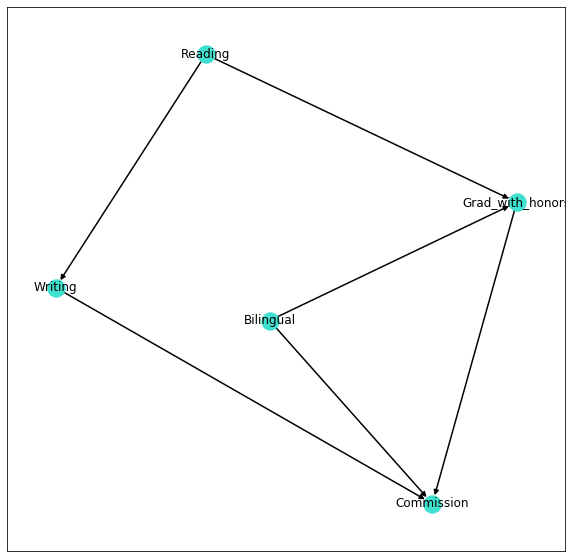

In [3]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
%matplotlib inline
np.random.seed(8)

DAG = nx.DiGraph()
DAG.add_edges_from(edges)

fig = plt.figure(figsize = (10,10))
pos = nx.spring_layout(DAG) #Position nodes computed by using Fruchterman-Reingold force-directed algorithm.
nx.draw_networkx_nodes(DAG, pos=pos, node_color='turquoise')
nx.draw_networkx_labels(DAG, pos=pos)
nx.draw_networkx_edges(DAG, pos=pos, edge_color='black', width = 1.5, arrows=True)
plt.show()


### 1.1 Conditional Probability Distributions
In order to make predictions with our model, we need to define the conditional probability distribution (CPD) of each variable. By looking at the figure above, we can easily conclude that:
* $Reading$ and $Bilingual$ have only prior probabilities $\implies$ 2 entrances in the corresponding CPD tables;
* $Writing$, $Grad\_with\_honors$ and $Commission$ have conditional probabilities $\implies$ 4,8 and 16 entrances in the corresponding CPD tables. 

In [4]:
from pgmpy.factors.discrete import TabularCPD

reading_cpd=TabularCPD('Reading',2,[[.7,.3]]) #Less/more than 3 books per month
bilingual_cpd=TabularCPD('Bilingual',2,[[.85,.15]]) #Not bilingual/bilingual
writing_cpd=TabularCPD('Writing',2,[[.85,.4],[.15,.6]],
                       evidence=['Reading'],
                       evidence_card=[2]) #Poor/High writing skills given Reading
graduation_cpd=TabularCPD('Grad_with_honors',2,[[.65,.3,.55,.2],[.35,.7,.45,.8]],
                       evidence=['Bilingual','Reading'],
                       evidence_card=[2,2]) #Graduation withot/with honors given Reading and Bilingual
commission_cpd=TabularCPD('Commission',2,[[.95,.73,.7,.23,.35,.20,.28,.1],[.05,.27,.3,.77,.65,.8,.72,.9]],
                       evidence=['Grad_with_honors','Bilingual','Writing'],
                       evidence_card=[2,2,2]) #Not getting/getting the commission given Writing, Bilingual and Grad_with_honors

model.add_cpds(reading_cpd,
               bilingual_cpd,
               writing_cpd,
               graduation_cpd,
               commission_cpd)

#Verify the model correctness by:
#  -checking if the sum of the probabilities for each state is equal to 1;
#  -checking if the CPDs associated with nodes are consistent with their parents.
if model.check_model():
    print("No errors in the defined model.")

No errors in the defined model.


## 2. Independency
To reason about independence relations among the nodes of a Bayesian network we can rely on the **Markov blanket** and the **d-separation principle**.


### 2.1 Markov blanket
The *Markov blanket* of a given node consists in the set of its parents, its children and its children's other parents. Moreover, given the Markov blanket of a node, the node itself becomes independent from any other nodes of the network.<br>
In the figures below I display each node (*turquoise*) with its Markov blanket (*yellow*) and the remaining nodes (*gray*).

-------------------------------------------------------------------------------- 

Grad_with_honors 
Markov blanket -> ['Bilingual', 'Writing', 'Reading', 'Commission']


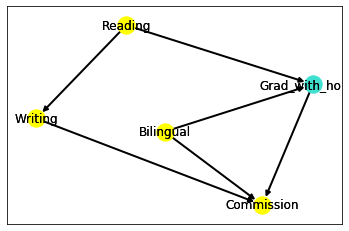

-------------------------------------------------------------------------------- 

Bilingual 
Markov blanket -> ['Grad_with_honors', 'Writing', 'Reading', 'Commission']


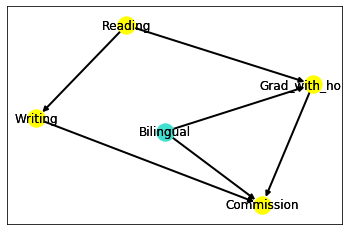

-------------------------------------------------------------------------------- 

Writing 
Markov blanket -> ['Bilingual', 'Grad_with_honors', 'Reading', 'Commission']


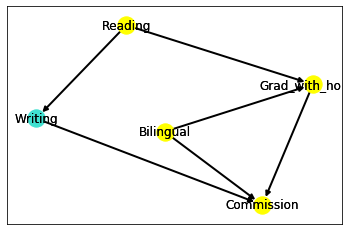

-------------------------------------------------------------------------------- 

Reading 
Markov blanket -> ['Writing', 'Grad_with_honors', 'Bilingual']


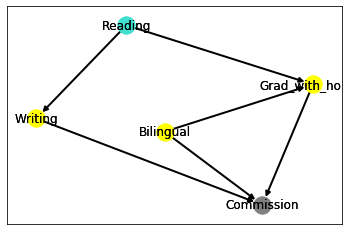

In [5]:
leaves = model.get_leaves()
markov_blanket = {}

for node in nodes:
    if not node in leaves:
        markov_blanket[node] = model.get_markov_blanket(node)
        print("-"*80,"\n")
        print(node, "\nMarkov blanket ->", markov_blanket[node])
        val_map = {'A': 1.0,
           'D': 0.5714285714285714,
           'H': 0.0}

        values = [val_map.get(node, 0.25) for node in DAG.nodes()]
        nx.draw_networkx_nodes(DAG, pos, nodelist=[node], node_color='turquoise')
        nx.draw_networkx_nodes(DAG, pos, nodelist=markov_blanket[node], node_color='yellow')
        nx.draw_networkx_nodes(DAG, pos, nodelist=[n for n in nodes if n not in markov_blanket[node] and n != node], node_color='grey')
        nx.draw_networkx_labels(DAG, pos)
        nx.draw_networkx_labels(DAG, pos)
        nx.draw_networkx_edges(DAG, pos, edge_color='black', width = 2.0, arrows=True)
        plt.show()
        

### 2.2 d-separation principle
The *d-separation principle* allows us to determine whether a set $X$ of variables is independent of another set $Y$, given a third set $Z$.<br>
The main idea is to associate *dependence* with *connectedness*, and *independence* with *separation*. Therefore, the *d-separation* is strictly related to the concept of *active-trail* in a directed graph:<br><br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; *if there is no active trail between two variables $X$ and $Y$, then $X$ and $Y$ are d-separated*.


As an example, let's consider the *V-structure* made up of the variables $Bilingual$ and $Reading$, and let's verify its correctness using the method `is_active_trail`. 

In [6]:
print(model.is_active_trail('Bilingual','Reading'))
print(model.is_active_trail('Bilingual','Reading','Grad_with_honors'))
print(model.is_active_trail('Bilingual','Reading','Commission'))

False
True
True


Let's now determine the marginal and conditional independence relations in our network by using the `get_independecies` method, which is based on the *d-separation principle*.

In [7]:
model.get_independencies()

(Grad_with_honors _|_ Writing | Reading)
(Grad_with_honors _|_ Writing | Reading, Bilingual)
(Commission _|_ Reading | Grad_with_honors, Writing, Bilingual)
(Bilingual _|_ Writing, Reading)
(Bilingual _|_ Reading | Writing)
(Bilingual _|_ Writing | Reading)
(Bilingual _|_ Writing | Grad_with_honors, Reading)
(Writing _|_ Bilingual)
(Writing _|_ Grad_with_honors, Bilingual | Reading)
(Writing _|_ Bilingual | Grad_with_honors, Reading)
(Writing _|_ Grad_with_honors | Reading, Bilingual)
(Reading _|_ Bilingual)
(Reading _|_ Bilingual | Writing)
(Reading _|_ Commission | Grad_with_honors, Writing, Bilingual)

## 3. Inference
There are two classes of inference methods: the **exact inference** and the **approximate inference**. In the former, we analytically compute the conditional probability distribution over the variables of interest using the posterior probability distributions. In the latter, we approximate the required posterior probability distributions using sampling methods or optimization techniques.<br><br>
Thanks to the inference methods, we can execute:
* a **conditional probability query** (i.e. asking for the probability that a node $X$ has a particular value $x$ given the evidence of $Y$ being equal to $y$, formally $P(X=x \mid Y=y)$);
* a **MAP query** (i.e. asking for the most likely explanation for some evidence - Maximum A-posteriori Probability). 

### 3.1 Exact inference
A very well known algorithm to perform exact inference on graphical models is the **Variable Elimination (VE)**.<br>
In the lines below I test VE by asking for: 
* the prior probability distribution of $Commission$;
* the probability distribution of $Commission$ given the evidence $Writing = poor$;
* the probability distribution of $Reading$ and $Bilingual$ given $Commission = no$;
* the MAP of the evidence $Reading =\quad> 3$.

In [8]:
from pgmpy.inference import VariableElimination

exact_inference = VariableElimination(model)

query1 = exact_inference.query(['Commission'])
query2 = exact_inference.query(['Commission'],{'Writing':0}) #Evidential reasoning
query3 = exact_inference.query(['Writing', 'Bilingual'], {'Commission':0}) #Intercausal reasoning
query4 = exact_inference.map_query(['Commission', 'Writing', 'Grad_with_honors'], {'Reading':1}) #MAP

print('\nP(Commission)\n\n',query1)
print('\n\nP(Commission|Writing=poor)\n\n',query2)
print('\n\nP(Reading, Bilingual|Commission=no)\n\n',query3)
print('\n\nMAP of Reading = > 3\n\n',query4)

Eliminating: Bilingual: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 335.04it/s]


P(Commission)

 +---------------+-------------------+
| Commission    |   phi(Commission) |
+===============+===================+
| Commission(0) |            0.5901 |
+---------------+-------------------+
| Commission(1) |            0.4099 |
+---------------+-------------------+


P(Commission|Writing=poor)

 +---------------+-------------------+
| Commission    |   phi(Commission) |
+===============+===================+
| Commission(0) |            0.6720 |
+---------------+-------------------+
| Commission(1) |            0.3280 |
+---------------+-------------------+


P(Reading, Bilingual|Commission=no)

 +------------+--------------+--------------------------+
| Writing    | Bilingual    |   phi(Writing,Bilingual) |
+============+==============+==========================+
| Writing(0) | Bilingual(0) |                   0.7258 |
+------------+--------------+--------------------------+
| Writing(0) | Bilingual(1) |                   0.0884 |
+------------+--------------+---------

### 3.2 Approximate inference
The main problem in performing exact inference is that it's carried out with posterior probabilities which are not always tractable. The approximate inference addresses this issue by sampling form the untractable posterior (**stochastic methods**) or by approximating the posterior with a tractable distribution (**deterministic methods**).<br><br>
In the lines below I compare three sampling methods (*Weighted Likelihood* (WL), *Rejection Sampling* (RS) and *Gibbs Sampling* (GS)) using the VE result as reference. I query the model for $P(Reading = \quad > 3 \mid Bilingual = yes, Commission = no)$ and I run 10 experiments with an increasing number of samples. As expected, the probability inferred using the stochastic methods progressively converges to the reference value (see the figure below).

In [8]:
# Exact Inference

query = exact_inference.query(['Reading'], {'Bilingual' : 1,'Commission' : 0})
print("\nP(Reading | Bilingual = yes, Commission = no)\n\n",query)

reference_prob = query.values[1]

Eliminating: Grad_with_honors: 100%|████████████████████████████████████████████████████| 2/2 [00:00<00:00, 400.99it/s]


P(Reading | Bilingual = yes, Commission = no)

 +------------+----------------+
| Reading    |   phi(Reading) |
+============+================+
| Reading(0) |         0.8292 |
+------------+----------------+
| Reading(1) |         0.1708 |
+------------+----------------+


In [9]:
from pgmpy.sampling import BayesianModelSampling
from pgmpy.factors.discrete import State
from pgmpy.sampling import GibbsSampling

BMS_inference = BayesianModelSampling(model)
gibbs = GibbsSampling(model)

evidence = [State('Bilingual',1), State('Commission',0)]

def prob_WL(samples,variable):
    return round(np.sum(np.dot(samples[variable],samples['_weight']))/np.sum(samples['_weight']),2)

def prob_Gibbs(samples):
    return (samples.query('Reading == 1 & Bilingual == 1 & Commission == 0').shape[0]
                /
            samples.query('Bilingual == 1 & Commission == 0').shape[0])
    
def run_experiment(sample_size):
    # Sample
    samples_WL = BMS_inference.likelihood_weighted_sample(evidence = evidence, size=sample_size, return_type='recarray')
    samples_RS = BMS_inference.rejection_sample(evidence=evidence, size=sample_size, return_type='recarray')
    samples_GS= gibbs.sample(size = size)
    
    # Probability
    results_WL = prob_WL(samples_WL,'Reading')
    results_RS = np.recarray.mean(samples_RS['Reading'], axis=0)
    results_GS = prob_Gibbs(samples_GS)
    
    # Return results
    return np.array([(sample_size, 
                      results_WL,
                      results_RS,
                      results_GS)], 
                    dtype=[('sample_size', '<i8'), 
                           ('results_WL', '<f8'),
                           ('results_RS', '<f8'),
                           ('results_GS', '<f8')])


In [10]:
#Approximate Inference

approximate_results = np.array([], dtype=[('sample_size', '<i8'), 
                           ('results_WL', '<f8'),
                           ('results_RS', '<f8'),
                           ('results_GS', '<f8')])
initial_size = 2
final_size = 5
num = 10 

for size in np.logspace(initial_size, final_size, num=num, dtype='<i8'):
    approximate_results=np.append(approximate_results,run_experiment(size))
    
print(approximate_results)

Generating for node: Commission: 100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 98.30it/s]

Generating for node: Commission: 100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.39it/s]
186it [00:00, 518.10it/s]                                                                                              
Generating for node: Commission: 100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 69.63it/s]

Generating for node: Commission: 100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.51it/s]
359it [00:00, 414.34it/s]                                                                                              
Generating for node: Commission: 100%|███████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.79it/s]
731it [00:01, 503.09it/s]                                                                                              
Generating for node: Commission: 100%|

Generating for node: Commission: 100%|███████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.48s/it]
14678it [00:29, 505.79it/s]                                                                                            
Generating for node: Commission: 100%|███████████████████████████████████████████████████| 5/5 [00:56<00:00, 11.26s/it]
31470it [01:00, 520.28it/s]                                                                                            
Generating for node: Commission: 100%|███████████████████████████████████████████████████| 5/5 [01:48<00:00, 21.71s/it]
67495it [01:56, 580.12it/s]                                                                                            
Generating for node: Commission: 100%|███████████████████████████████████████████████████| 5/5 [03:35<00:00, 43.08s/it]
144611it [03:50, 626.84it/s]                                                                                           
100%|███████████████████████████████████

[(   100, 0.19, 0.19      , 0.5       )
 (   215, 0.18, 0.20465116, 0.2       )
 (   464, 0.17, 0.17672414, 0.15384615)
 (  1000, 0.17, 0.18      , 0.27777778)
 (  2154, 0.16, 0.18709378, 0.23931624)
 (  4641, 0.17, 0.16418875, 0.18181818)
 ( 10000, 0.17, 0.1633    , 0.18197574)
 ( 21544, 0.17, 0.16928147, 0.17205998)
 ( 46415, 0.17, 0.17483572, 0.17439632)
 (100000, 0.17, 0.17133   , 0.17571552)]


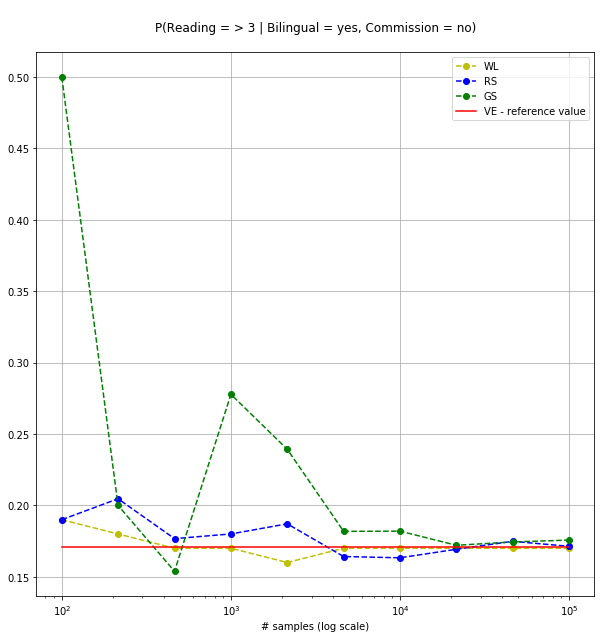

In [13]:
# Compare the results

plt.figure(figsize=(10,10))
plt.grid(True)
plt.title('\nP(Reading = > 3 | Bilingual = yes, Commission = no)\n')
plt.xlabel("# samples (log scale)")

sizes = approximate_results['sample_size']
results_WL = approximate_results['results_WL']
results_RS = approximate_results['results_RS']
results_GS = approximate_results['results_GS']

plot_WL, = plt.semilogx(sizes, results_WL, 'yo--', label="WL")
plot_RS, = plt.semilogx(sizes, results_RS, 'bo--', label="RS")
plot_GS,= plt.semilogx(sizes, results_GS, 'go--', label="GS")
plot_VE,= plt.semilogx(sizes, reference_prob*np.ones(len(sizes)),'r', label="VE - reference value")

plt.legend(handles=[plot_WL, plot_RS, plot_GS, plot_VE])
plt.show()